In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Creat an empty 8-bit 200*200 image

In [2]:
img_width, img_height = 200, 200
rect_width, rect_height = 90, 50
# Creat empty image
img = np.zeros((img_width, img_height), dtype=np.uint8)
# Fit in the rectangle
img[(img_height//2 - rect_height//2):(img_height//2 + rect_height//2), (img_width//2 - rect_width//2):(img_width//2 + rect_width//2)] = 255

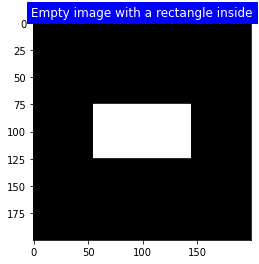

In [3]:
plt.title('Empty image with a rectangle inside', color='white', backgroundcolor='blue')
plt.imshow(img, cmap = 'gray')

### Apply affine transformations

##### Define translation function

In [4]:
def translation_func(img, x_trans, y_trans):
    # get the image shape
    rows, cols = img.shape
    # transformation matrix for translation
    M = np.float32([[1, 0, x_trans],
                    [0, 1, y_trans],
                    [0, 0, 1]])
    translated_img = cv2.warpPerspective(img, M, (cols, rows))
    return translated_img

##### Define rotation function

In [5]:
def rotation_func(img, _angle):
	# get the image shape
	rows, cols = img.shape
	#angle from degree to radian
	# angle = np.radians(_angle)
	#transformation matrix for Rotation
	image_center = tuple(np.array(img.shape[1::-1]) / 2)
	rot_mat = cv2.getRotationMatrix2D(image_center, _angle, 1.0)
	# apply a affine transformation to the image
	rotated_img = cv2.warpAffine(img, rot_mat, (int(cols),int(rows)))
	# rotated_img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
	return rotated_img

##### Translate the image by 30 pixels in the opposite x direction

In [6]:
x_translated_image = translation_func(img, -30, 0)

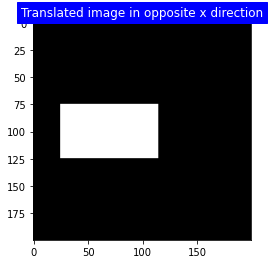

In [7]:
plt.title('Translated image in opposite x direction', color='white', backgroundcolor='blue')
plt.imshow(x_translated_image, cmap = 'gray')

##### Translate the image by 20 pixels in the y direction

In [8]:
y_translated_image = translation_func(img, 0, 20)

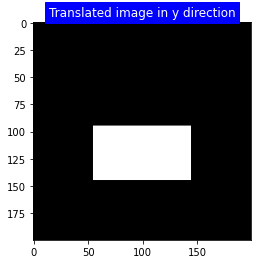

In [9]:
plt.title('Translated image in y direction', color='white', backgroundcolor='blue')
plt.imshow(y_translated_image, cmap = 'gray')

##### Rotate the image by 40 degrees

In [10]:
rotated_40_image = rotation_func(img, -40)

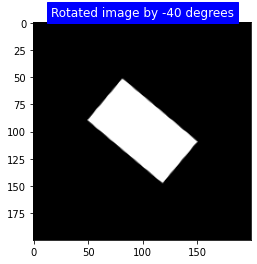

In [11]:
plt.title('Rotated image by -40 degrees', color='white', backgroundcolor='blue')
plt.imshow(rotated_40_image, cmap = 'gray')

##### Rotate image by -90 degrees

In [12]:
rotated_90_image = rotation_func(img, 90)

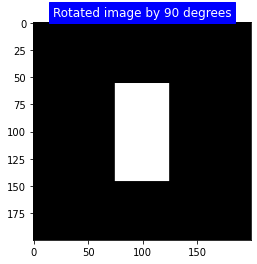

In [13]:
plt.title('Rotated image by 90 degrees', color='white', backgroundcolor='blue')
plt.imshow(rotated_90_image, cmap = 'gray')

### Calculate the fourier transformation of the resulted images and display the results

##### Define fourier transform function

In [14]:
def fourier_transform(img):
    _fft = np.fft.fft2(img)
    # shift zero-frequency component to the center  
    fourier_t_image = np.fft.fftshift(_fft)
    return fourier_t_image

In [15]:
def plot_fourier_t(img):
    # perform the fourier transformation
    fourier_t_image = fourier_transform(np.float64(img))

    # calculate log scaled magnitude of the image
    magnitude = np.abs(fourier_t_image)
    log_magnitude = np.log(magnitude + 1)

    # calculate the phase of the image
    phase = np.angle(fourier_t_image)

    # Plot
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(1, 4)

    # original image
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original image', color='white', backgroundcolor='blue')

    # Fourier transform
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(magnitude, cmap='gray')
    ax2.set_title('Log scaled magnitude', color='white', backgroundcolor='blue')

    # Log scaled magnitude
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.imshow(log_magnitude, cmap='gray')
    ax2.set_title('Log scaled magnitude', color='white', backgroundcolor='blue')

    # Phase
    ax2 = fig.add_subplot(gs[0, 3])
    ax2.imshow(phase, cmap='gray')
    ax2.set_title('Phase', color='white', backgroundcolor='blue')

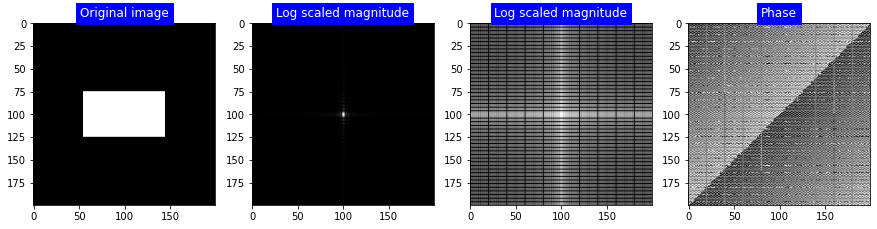

In [16]:
plot_fourier_t(img)

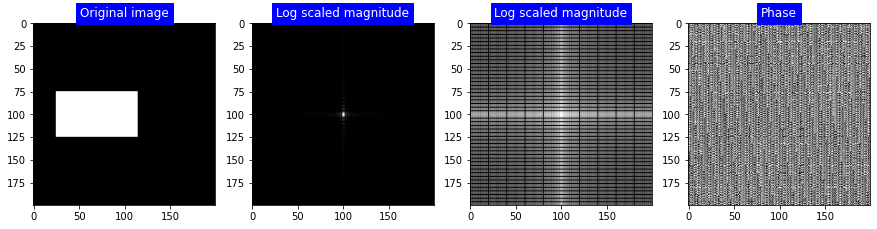

In [17]:
plot_fourier_t(x_translated_image)

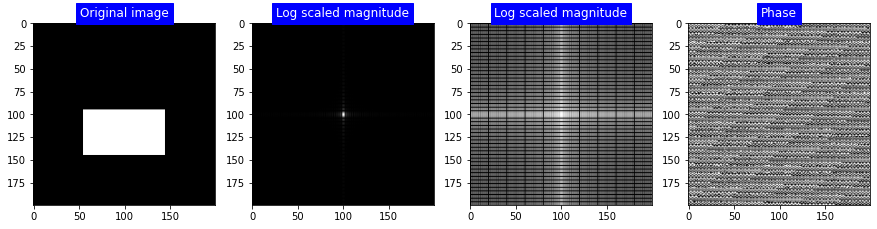

In [18]:
plot_fourier_t(y_translated_image)

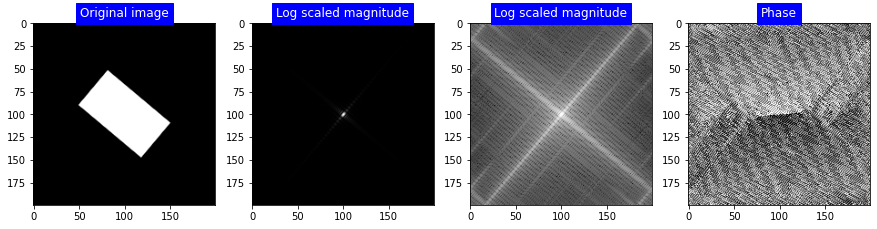

In [19]:
plot_fourier_t(rotated_40_image)

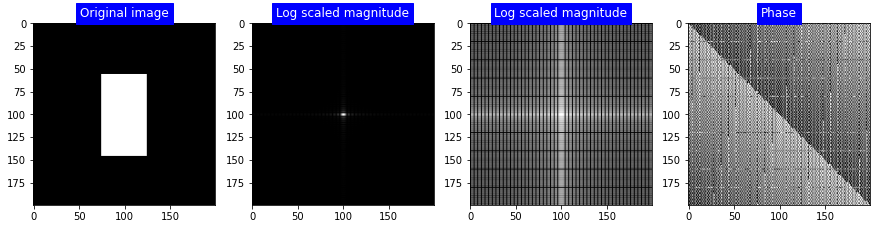

In [20]:
plot_fourier_t(rotated_90_image)

### Display zero frequency values

In [21]:
fourier_t_image = np.fft.fft2(np.float64(img))
# get zero-frequency row
zf_row = fourier_t_image[0, :]
# get the real and imaginary values
x_zf_row = [zfr_x.real for zfr_x in zf_row]
y_zf_row = [zfr_y.imag for zfr_y in zf_row]

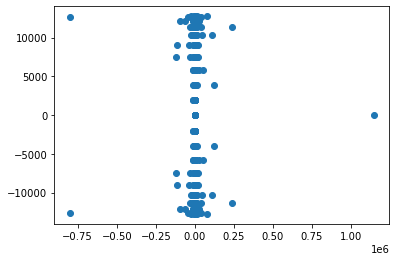

In [22]:
plt.scatter(x_zf_row, y_zf_row)

In [23]:
# get zero-frequency col
zf_col = fourier_t_image[:, 0]
# get the real and imaginary values
x_zf_col = [zfr_x.real for zfr_x in zf_col]
y_zf_col = [zfr_y.imag for zfr_y in zf_col]

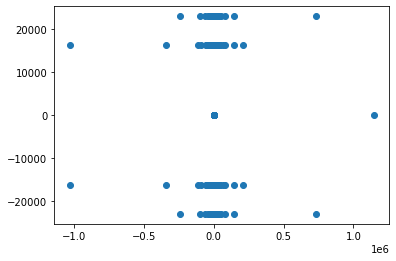

In [24]:
plt.scatter(x_zf_col, y_zf_col)

### Load chest image in gray-scale

In [25]:
chest_img = cv2.imread('chest.tif', cv2.IMREAD_GRAYSCALE)

In [26]:
chest_fourier_image = fourier_transform(chest_img)
chest_magnitude = np.abs(chest_fourier_image)
chest_log_magnitude = np.log(chest_magnitude + 1)

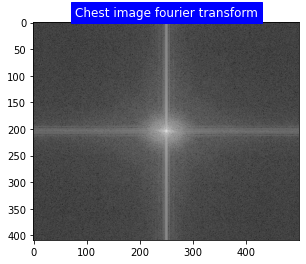

In [27]:
plt.title('Chest image fourier transform', color='white', backgroundcolor='blue')
plt.imshow(chest_log_magnitude, cmap = 'gray')

### Apply band-reject filtering

##### Define band-reject function

In [28]:
def band_rej_filtering(fourier_im, inner_r, outer_r):
    center = (fourier_im.shape[1]// 2, fourier_im.shape[0]// 2)
    filter = np.ones(fourier_im.shape, dtype=np.uint8)
    # make a circle
    cv2.circle(filter, center, outer_r, 0, -1)
    cv2.circle(filter, center, inner_r, 1, -1)
    return fourier_im*filter

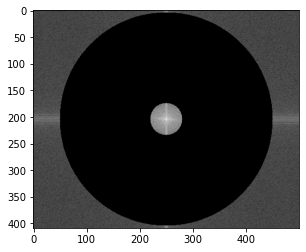

In [29]:
band_rejected_fourier_image = band_rej_filtering(chest_fourier_image, 30, 200)
plt.imshow(np.log(np.abs(band_rejected_fourier_image) + 1), cmap='gray')

#### Perform inverse fourier transform on the band-rejected image

In [30]:
def inverse_fourier_trans(fourier_im):
    centered_img = np.fft.ifftshift(fourier_im)
    inverse_fourier = np.fft.ifft2(centered_img)
    return inverse_fourier

In [31]:
band_rejected_img = inverse_fourier_trans(band_rejected_fourier_image)

Text(0.5, 1.0, 'Band-rejected image')

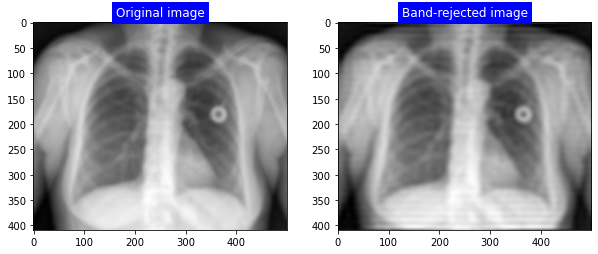

In [32]:
# Plot
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(1, 2)

# original image
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(chest_img, cmap='gray')
ax1.set_title('Original image', color='white', backgroundcolor='blue')

# Band-rejected image
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(np.abs(band_rejected_img), cmap='gray')
ax2.set_title('Band-rejected image', color='white', backgroundcolor='blue')

### Mirror the image around center using fourier transform concepts

In [33]:
flipped_img = np.flip(band_rejected_fourier_image, 0)
mirrored_fourier_img = np.flip(flipped_img, 1)

In [34]:
mirrored_img = inverse_fourier_trans(mirrored_fourier_img)

##### Display result

Text(0.5, 1.0, 'Mirrored image around center')

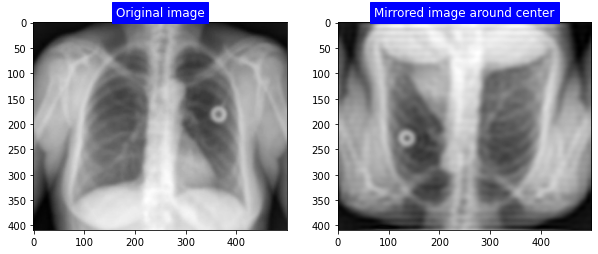

In [35]:
# Plot
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(1, 2)

# original image
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(chest_img, cmap='gray')
ax1.set_title('Original image', color='white', backgroundcolor='blue')

# mirrored image
ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(np.abs(mirrored_img), cmap='gray')
ax1.set_title('Mirrored image around center', color='white', backgroundcolor='blue')

### Display input, output and frequency domain

Text(0.5, 1.0, 'Frequency domain image')

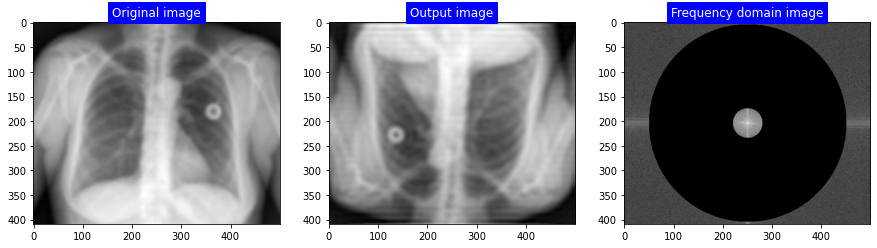

In [36]:
# Plot
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(1, 3)

# original image
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(chest_img, cmap='gray')
ax1.set_title('Original image', color='white', backgroundcolor='blue')

# Output image
ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(np.abs(mirrored_img), cmap='gray')
ax1.set_title('Output image', color='white', backgroundcolor='blue')

# Frequency domain image
ax1 = fig.add_subplot(gs[0, 2])
plt.imshow(np.log(np.abs(band_rejected_fourier_image) + 1), cmap='gray')
ax1.set_title('Frequency domain image', color='white', backgroundcolor='blue')